# Setup

In [1]:
from feature_lens.core.types import *
from feature_lens.utils.device_manager import DeviceManager
from feature_lens.utils.viz import *
from feature_lens.utils.data_utils import *
from feature_lens.utils.load_pretrained import load_model, load_sae
from feature_lens.data.make_ioi import make_ioi
from feature_lens.data.string_handler import as_dataframe

DeviceManager.instance().set_device("cuda")


/home/daniel/ml_workspace/feature-lens/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd 
pd.set_option('display.max_colwidth', None)

model = load_model("gpt2-small")
ioi_data = make_ioi(model)
df = as_dataframe(ioi_data)
df

Loaded pretrained model gpt2-small into HookedTransformer


,clean_prompt,corrupt_prompt,answer,wrong_answer
0,"When John and Mary went to the shops, Mary gave the bag to","When John and Mary went to the shops, John gave the bag to",John,Mary
1,"When John and Mary went to the shops, John gave the bag to","When John and Mary went to the shops, Mary gave the bag to",Mary,John
2,"When Tom and James went to the park, James gave the ball to","When Tom and James went to the park, Tom gave the ball to",Tom,James
3,"When Tom and James went to the park, Tom gave the ball to","When Tom and James went to the park, James gave the ball to",James,Tom
4,"When Dan and Sid went to the shops, Sid gave an apple to","When Dan and Sid went to the shops, Dan gave an apple to",Dan,Sid
5,"When Dan and Sid went to the shops, Dan gave an apple to","When Dan and Sid went to the shops, Sid gave an apple to",Sid,Dan
6,"After Martin and Amy went to the park, Amy gave a drink to","After Martin and Amy went to the park, Martin gave a drink to",Martin,Amy
7,"After Martin and Amy went to the park, Martin gave a drink to","After Martin and Amy went to the park, Amy gave a drink to",Amy,Martin


In [3]:
sae_up = load_sae(release = "gpt2-small-res-jb", sae_id = "blocks.8.hook_resid_pre")
sae_target = load_sae(release = "gpt2-small-hook-z-kk", sae_id="blocks.8.hook_z")
sae_down = load_sae(release = "gpt2-small-res-jb", sae_id = "blocks.9.hook_resid_pre")
sae_up_hook_point = "blocks.8.hook_resid_pre.hook_sae_acts_post"
sae_target_hook_point = "blocks.8.attn.hook_z.hook_sae_acts_post"
sae_down_hook_point = "blocks.9.hook_resid_pre.hook_sae_acts_post"

saes = [sae_up, sae_target, sae_down]

In [4]:
SAE_TARGET_FEATURE = 16513

In [5]:
from feature_lens.cache import get_sae_cache

with model.saes(saes):
    clean_cache = get_sae_cache(model, ioi_data, input="clean")
    corrupt_cache = get_sae_cache(model, ioi_data, input="corrupt")

# Investigating target feature

In [6]:
# Plot the average activation over all tokens

import matplotlib.pyplot as plt
import plotly.express as px

# Sum of activations per example
# shape: (batch,)
clean_acts_summed = clean_cache[sae_target_hook_point][:, :, SAE_TARGET_FEATURE].sum(dim=1)
clean_acts_np = clean_acts_summed.detach().cpu().numpy()

for clean_prompt in ioi_data.clean_prompts:
  print(clean_prompt)

px.bar(range(len(clean_acts_np)), clean_acts_np)


When John and Mary went to the shops, Mary gave the bag to
When John and Mary went to the shops, John gave the bag to
When Tom and James went to the park, James gave the ball to
When Tom and James went to the park, Tom gave the ball to
When Dan and Sid went to the shops, Sid gave an apple to
When Dan and Sid went to the shops, Dan gave an apple to
After Martin and Amy went to the park, Amy gave a drink to
After Martin and Amy went to the park, Martin gave a drink to


In [7]:
# Visualize which tokens it's firing on

from circuitsvis.tokens import colored_tokens

for example_idx in range(ioi_data.get_batch_size()):
    sae_target_clean_acts = clean_cache[sae_target_hook_point][example_idx, :, SAE_TARGET_FEATURE]
    display(colored_tokens(ioi_data.clean_str_tokens[example_idx], sae_target_clean_acts))

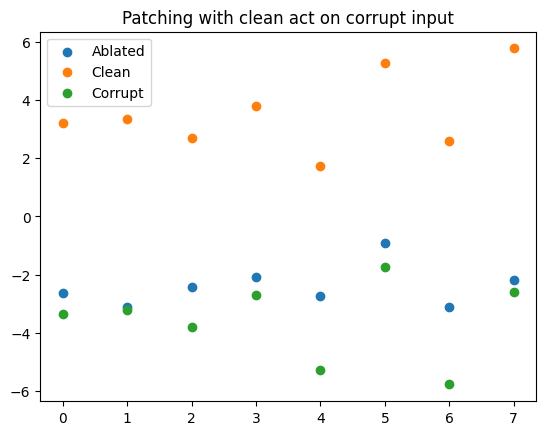

In [8]:
from feature_lens.ablate import make_ablate_hook

clean_metric = ioi_data.get_metric(ioi_data.get_logits(model, input = "clean"))
corrupt_metric = ioi_data.get_metric(ioi_data.get_logits(model, input = "corrupt"))

# Make patch hook for clean cache
hooks = [make_ablate_hook(clean_cache, sae_target_hook_point, SAE_TARGET_FEATURE)]
with model.saes(saes):
    with model.hooks(
        fwd_hooks=hooks,
    ):
        # Run on the corrupt input
        ablated_logits = ioi_data.get_logits(model, input = "corrupt")
        ablated_metric = ioi_data.get_metric(ablated_logits)

# Plot
x = range(ioi_data.get_batch_size())

plt.figure()
plt.title("Patching with clean act on corrupt input")
plt.scatter(x = x, y = ablated_metric.detach().cpu().numpy(), label='Ablated')
plt.scatter(x = x, y = clean_metric.detach().cpu().numpy(), label='Clean')
plt.scatter(x = x, y = corrupt_metric.detach().cpu().numpy(), label='Corrupt')
plt.legend()
plt.show()

# Finding relevant upstream features via Attribution Patching

In [9]:
from feature_lens.attribute import get_sae_cache_for_target_feature_as_metric, compute_attribution

# Run the attribution code inside a context to prevent overwriting clean_cache, corrupt_cache
def compute_attribution_helper():
    with model.saes(saes):
        clean_cache = get_sae_cache_for_target_feature_as_metric(model, ioi_data, sae_target_hook_point, SAE_TARGET_FEATURE)
        corrupt_cache = get_sae_cache_for_target_feature_as_metric(model, ioi_data,  sae_target_hook_point, SAE_TARGET_FEATURE, input = "corrupt")
    attribution = compute_attribution(sae_up_hook_point, clean_cache, corrupt_cache)
    return attribution

sae_up_attrib = compute_attribution_helper()

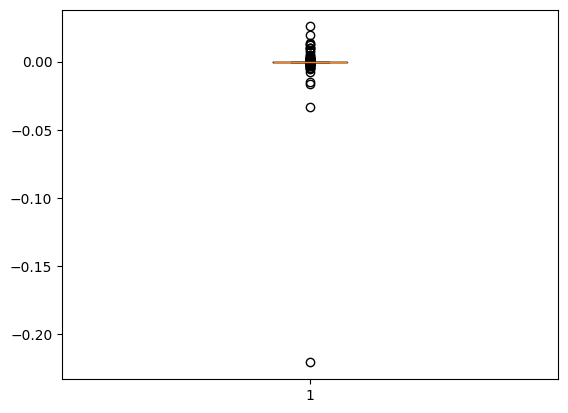

In [10]:
import matplotlib.pyplot as plt

sae_up_attrib_summed = sae_up_attrib.sum(dim=1).mean(dim=0)
sae_up_attrib_np = sae_up_attrib_summed.detach().cpu().numpy()

plt.boxplot(sae_up_attrib_np)
plt.show()


In [26]:
from jaxtyping import Float
from collections import namedtuple

FeatureScores = namedtuple("FeatureScores", ["scores", "features"])

def get_topk_and_botk_scores_and_features(scores: Float[torch.Tensor, " n"], k: int = 10):
    topk_scores, topk_features = torch.topk(scores, k = k)
    botk_scores, botk_features = torch.topk(-scores, k = k)
    botk_scores = -1 * botk_scores
    topk_features = topk_features.cpu().numpy().tolist()
    botk_features = botk_features.cpu().numpy().tolist()
    return FeatureScores(topk_scores, topk_features), FeatureScores(botk_scores, botk_features)

In [27]:
sae_up_topk, sae_up_botk = get_topk_and_botk_scores_and_features(sae_up_attrib_summed)


<BarContainer object of 10 artists>

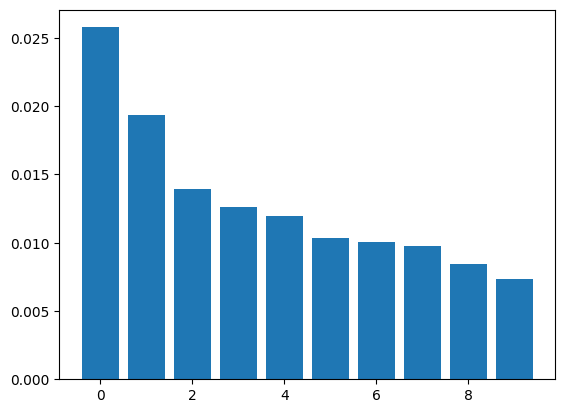

In [28]:
# Plot top 10 scores
plt.bar(range(10), sae_up_topk.scores.detach().cpu().numpy())

<BarContainer object of 10 artists>

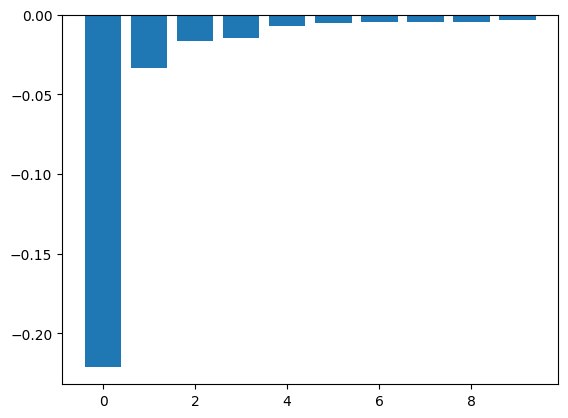

In [29]:
# Plot bot 10 scores
plt.bar(range(10), sae_up_botk.scores.detach().cpu().numpy())

In [21]:
from feature_lens.utils.neuronpedia import get_neuronpedia_url

UP_LAYER = 8
print(get_neuronpedia_url(UP_LAYER, sae_up_topk.features, name = "top10_upstream"))
print(get_neuronpedia_url(UP_LAYER, sae_up_botk.features, name = "bot10_upstream"))

https://neuronpedia.org/quick-list/?name=top10_upstream&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-res-jb%22%2C%20%22index%22%3A%20%2214824%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-res-jb%22%2C%20%22index%22%3A%20%2217721%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-res-jb%22%2C%20%22index%22%3A%20%2211446%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-res-jb%22%2C%20%22index%22%3A%20%2222660%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-res-jb%22%2C%20%22index%22%3A%20%2212773%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-res-jb%22%2C%20%22index%22%3A%20%2215130%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-res-jb%22%2C%20%22index%22%3A%20%22600%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%228-res-jb%22%2C%20%22index%22%3A%20%2215434%2

In [14]:
# Visualize token activation patterns for topk features
for feature in sae_up_topk.features:
    print("Feature {}".format(feature))
    for example_idx in range(ioi_data.get_batch_size()):
        sae_target_clean_acts = clean_cache[sae_up_hook_point][example_idx, :, feature]
        display(colored_tokens(ioi_data.clean_str_tokens[example_idx], sae_target_clean_acts))

Feature 14824


Feature 17721


Feature 11446


Feature 22660


Feature 12773


Feature 15130


Feature 600


Feature 15434


Feature 6310


Feature 13525


# Finding relevant downstream features via Activation Patching

In [15]:
from feature_lens.ablate import make_ablate_hook

# Run the ablation code inside a context to prevent overwriting clean_cache, corrupt_cache
def compute_ablation_effect_helper():
    orig_sae_down_act = clean_cache[sae_down_hook_point]
    with model.saes(saes):
        # Ablate with the corrupt cache
        hooks = [make_ablate_hook(corrupt_cache, sae_target_hook_point, SAE_TARGET_FEATURE)]
        with model.hooks(
            fwd_hooks=hooks,
        ):
            # Run on the clean input
            _, ablated_cache = model.run_with_cache(ioi_data.clean_tokens)
            # NOTE: summing over token positions
            # TODO: not sure if this is right
            ablated_sae_down_act = ablated_cache[sae_down_hook_point]
            ablated_delta = (ablated_sae_down_act - orig_sae_down_act).sum(dim=1).mean(dim=0)
    return ablated_delta

ablated_delta = compute_ablation_effect_helper()

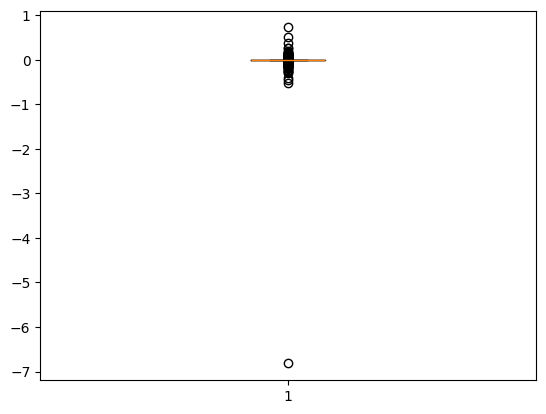

In [16]:
import matplotlib.pyplot as plt 

plt.boxplot(ablated_delta.detach().cpu().numpy())
plt.show()

In [32]:
sae_down_topk, sae_down_botk = get_topk_and_botk_scores_and_features(ablated_delta)

In [33]:
print(sae_down_topk.features)
print(sae_down_botk.features)

[3983, 3176, 10603, 16110, 15143, 21016, 17638, 22749, 23655, 6900]
[1721, 9434, 20520, 15147, 4497, 16001, 12934, 4322, 18404, 15807]


<BarContainer object of 10 artists>

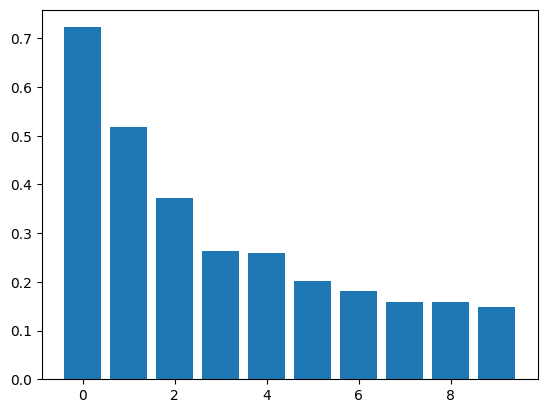

In [34]:
# Plot top 10 scores
plt.bar(range(10), sae_down_topk.scores.detach().cpu().numpy())

<BarContainer object of 10 artists>

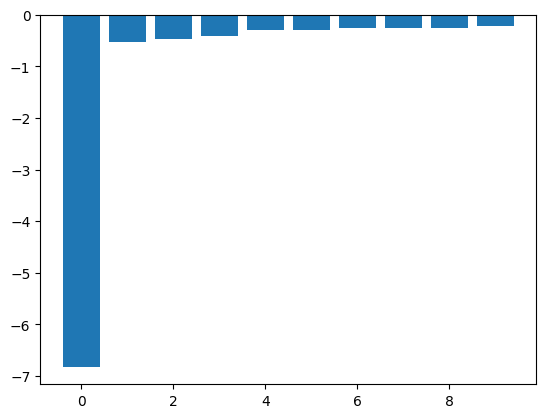

In [35]:
# Plot bot 10 scores
plt.bar(range(10), sae_down_botk.scores.detach().cpu().numpy())

In [36]:
DOWN_LAYER = 9
print(get_neuronpedia_url(DOWN_LAYER, sae_down_topk.features))
print(get_neuronpedia_url(DOWN_LAYER, sae_down_botk.features))

https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%223983%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%223176%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2210603%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2216110%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2215143%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2221016%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2217638%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%229-res-jb%22%2C%20%22index%22%3A%20%2222749%2

In [37]:
# Visualize token activation patterns for topk features
for feature in sae_down_topk.features:
    print("Feature {}".format(feature))
    for example_idx in range(ioi_data.get_batch_size()):
        sae_target_clean_acts = clean_cache[sae_down_hook_point][example_idx, :, feature]
        display(colored_tokens(ioi_data.clean_str_tokens[example_idx], sae_target_clean_acts))

Feature 3983


Feature 3176


Feature 10603


Feature 16110


Feature 15143


Feature 21016


Feature 17638


Feature 22749


Feature 23655


Feature 6900
